In [1]:
from src.utils.results_utils import *
from src.utils.data_utils import str_dict_to_values

[nltk_data] Downloading package words to
[nltk_data]     /Users/ainhoavilanova/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     /Users/ainhoavilanova/nltk_data...
[nltk_data]   Package names is already up-to-date!


# Ethnicity model

In [2]:
df_ethnicity = pd.read_csv('data/name_ethnicity.csv')
df_ethnicity.sample(10)

,Name,Country
2239,Leopoldo,Southeast Asian
1319,Giampiero,Romance
1478,Hana,Slavic
508,Bradford,Oceania
2768,Natallia,Slavic
2677,Miroslava,Slavic
1596,Hirotami,East Asian
3377,Severine,Romance
3050,ROSANA,Hispanic
3979,Yalennis,Hispanic


In [3]:
# Grouping by 'Country' and summing the occurrences
region_counts = df_ethnicity.groupby('Country').size()  # Count the number of names per country
region_counts.sort_values(ascending=False).head(14)

Country
Slavic                648
Germanic              626
English-Speaking      603
East Asian            486
Romance               480
Hispanic              376
Nordic                285
Oceania               197
South Asian           113
Middle Eastern         93
Sub-Saharan Africa     90
Southeast Asian        47
Baltic                 46
North Africa           25
dtype: int64

In [4]:
# Encode the 'Country' column as integers
df_ethnicity['Country'], legend = pd.factorize(df_ethnicity['Country'])

# Create a legend DataFrame
legend_df = pd.DataFrame({
    'Encoded Value': range(len(legend)),
    'Country': legend
})

print("\nLegend:")
legend_df.head(14)



Legend:


,Encoded Value,Country
0,0,Hispanic
1,1,Nordic
2,2,Germanic
3,3,English-Speaking
4,4,Slavic
5,5,Middle Eastern
6,6,North Africa
7,7,Romance
8,8,Sub-Saharan Africa
9,9,South Asian


In [5]:
df_ethnicity.sample(10)

,Name,Country
2370,MARCELO,0
2907,Ortrun,2
3791,Utkirbek,4
2930,Oussama,6
75,Aiko,10
302,Arnulf,2
3177,Riza,5
683,Cipriano,7
1004,Eleonora,4
2959,Paula,2


## 1. Name Lenght and Vowel/Consonant Count

In [6]:
def analyze_name(name):
    vowels = set('aeiouyAEIOUY')  
    consonants = set('bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ')  
    length = len(name)  
    vowel_count = sum(1 for char in name if char in vowels)  
    consonant_count = sum(1 for char in name if char in consonants)  
    return pd.Series({
        'Length': length,
        'Vowel Count': vowel_count,
        'Consonant Count': consonant_count,
        'Vowel/Consonant Ratio': vowel_count / consonant_count if consonant_count > 0 else 0
    })

def add_diacritic_columns_from_series(names, diacritics="áàäâãåéèëêíìïîóòöôõúùüûñçýÿ"):
    diacritic_set = set(diacritics)  # Convert diacritics to a set for faster lookup

    # Create a dictionary of columns for each diacritic
    diacritic_columns = {
        f"{diacritic}": names.apply(lambda name: 1 if diacritic in name.lower() else 0)
        for diacritic in diacritic_set
    }

    # Convert to DataFrame
    diacritic_df = pd.DataFrame(diacritic_columns)

    # Drop columns where no diacritics are found
    diacritic_df = diacritic_df.loc[:, (diacritic_df.sum(axis=0) > 0)]

    return diacritic_df

In [7]:
df_ethnicity = df_ethnicity.join(df_ethnicity['Name'].apply(analyze_name))

# Add diacritic columns to the DataFrame
diacritic_df = add_diacritic_columns_from_series(df_ethnicity['Name'])
df_ethnicity = df_ethnicity.join(diacritic_df) # Join the resulting columns to the original DataFrame

# Add Soundex encoding
from jellyfish import soundex
df_ethnicity['Soundex'] = df_ethnicity['Name'].apply(soundex)

# Perform one-hot encoding on Soundex and Country 
df_ethnicity = pd.concat([df_ethnicity, pd.get_dummies(df_ethnicity['Soundex'], prefix='Soundex')], axis=1)

# Drop the original Soundex column 
df_ethnicity.drop(columns=['Soundex'], inplace=True)

df_ethnicity.sample(10)

,Name,Country,Length,Vowel Count,Consonant Count,Vowel/Consonant Ratio,è,ü,ã,é,...,Soundex_Z432,Soundex_Z435,Soundex_Z500,Soundex_Z516,Soundex_Z550,Soundex_Z600,Soundex_Z610,Soundex_Z620,Soundex_Z650,Soundex_Z653
789,Dante,7,5.0,2.0,3.0,0.666667,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3256,Rustam,4,6.0,2.0,4.0,0.500000,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2040,Keeth,3,5.0,2.0,3.0,0.666667,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3457,Sizwe,8,5.0,2.0,3.0,0.666667,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1303,Germana,7,7.0,3.0,4.0,0.750000,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2282,Livio,7,5.0,3.0,2.0,1.500000,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2945,Paolo,7,5.0,3.0,2.0,1.500000,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1374,Gojko,4,5.0,2.0,3.0,0.666667,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
583,Carlos,0,6.0,2.0,4.0,0.500000,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
785,Danièle,7,7.0,3.0,3.0,1.000000,1,0,0,0,...,False,False,False,False,False,False,False,False,False,False


**Par rapport à Soundex :** Phonetic algorithm designed to index words (particularly names) based on their pronunciation rather than their spelling. This is especially useful when trying to find names that sound similar but are spelled differently.

## 2. N-Gram

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [9]:
# Correct ngram_range with two values: (2, 4)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))

# Fit and transform the 'Name' column
char_ngrams = vectorizer.fit_transform(df_ethnicity['Name'])

# Create a DataFrame with the n-gram features
ngram_df = pd.DataFrame(char_ngrams.toarray(), columns=vectorizer.get_feature_names_out())

# Convert to float32 to reduce memory usage
ngram_df = ngram_df.astype('float32')

# Output shape
print(ngram_df.shape)

(4115, 3967)


In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [11]:
# Standardize the data
scaler = StandardScaler()
ngram_scaled = scaler.fit_transform(ngram_df)

# Initialize PCA and fit the scaled data
n=800
pca = PCA(n_components=n)  # Choose the number of components
ngram_pca = pca.fit_transform(ngram_scaled)

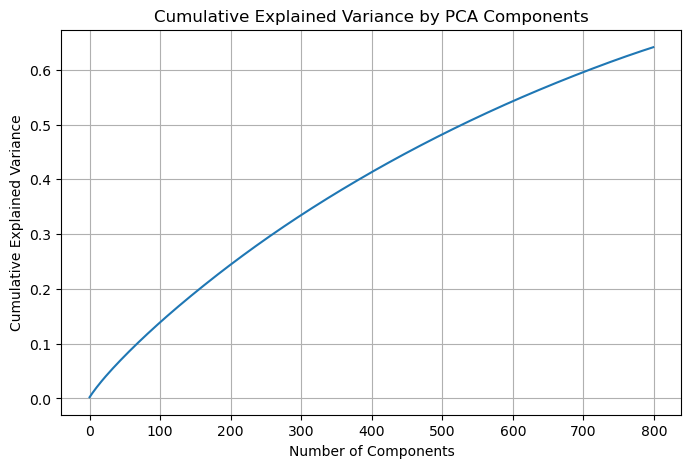

In [12]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()


In [13]:
# Create a DataFrame for the PCA-transformed data
pca_columns = [f'PC{i+1}' for i in range(n)]  # Generate column names PC1 to PC1000
ngram_pca_df = pd.DataFrame(ngram_pca, columns=pca_columns, index=ngram_df.index)  # Ensure indices match

# Merge the original DataFrame with the PCA DataFrame on their indices
df_ethnicity_pca = pd.concat([df_ethnicity, ngram_pca_df], axis=1)

df_ethnicity_pca.head()

,Name,Country,Length,Vowel Count,Consonant Count,Vowel/Consonant Ratio,è,ü,ã,é,...,PC791,PC792,PC793,PC794,PC795,PC796,PC797,PC798,PC799,PC800
0,ALDAIR,0,6.0,3.0,3.0,1.0,0,0,0,0,...,1.028550,-0.520831,0.665616,0.460395,-0.225016,-1.150169,-0.799913,1.192735,0.191655,0.906545
1,ALEX,0,4.0,2.0,2.0,1.0,0,0,0,0,...,0.351502,-0.096338,-0.525267,0.001540,0.313699,0.495039,0.266058,0.320859,0.199924,0.055259
2,ALEXANDRE,0,9.0,4.0,5.0,0.8,0,0,0,0,...,-0.166204,0.134336,-0.305499,-0.108649,-0.264736,0.172782,0.539291,0.880227,0.545436,0.258292
3,ALINE,0,5.0,3.0,2.0,1.5,0,0,0,0,...,0.176097,-0.256658,-0.365492,-0.334470,-0.240504,-0.283640,0.153490,0.391544,-0.025720,-0.409425
4,AMARAL,0,6.0,3.0,3.0,1.0,0,0,0,0,...,0.917731,0.476732,-0.648327,-0.316697,-0.811958,0.544327,-0.273428,-0.087002,-0.364922,0.615230


In [14]:
from sklearn.model_selection import train_test_split

# Define features and targets
X = df_ethnicity_pca.drop(columns=['Name','Country'])
y = df_ethnicity_pca['Country']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"There are {X_train.shape[0]} samples in the training set.")
print(f"There are {X_test.shape[0]} samples in the testing set.")

There are 3292 samples in the training set.
There are 823 samples in the testing set.


In [15]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

columns = ["Constant"] + list(df_ethnicity_pca.drop(columns=['Name','Country']).columns) 
df_X_train = pd.DataFrame(X_train, columns=columns)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Initialize the classifier
model = RandomForestClassifier(random_state=42)

# Train the classifier
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Accuracy: 0.3511543134872418
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.14      0.19        78
           1       0.25      0.07      0.11        54
           2       0.28      0.42      0.34       132
           3       0.28      0.38      0.32       120
           4       0.37      0.58      0.45       123
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00         7
           7       0.34      0.28      0.30        94
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        28
          10       0.55      0.93      0.69        82
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        46
          13       0.33      0.07      0.11        15

    accuracy                           0.35       823
   macro avg       0.19      0.20      0.18       823
weighted avg       0.29     

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# List to store results
results = []

# Iterate over the number of PCA components
for n in range(1, X.shape[1] + 1):
    # Apply PCA with n components
    pca = PCA(n_components=n)
    X_reduced = pca.fit_transform(X)

    # Train and evaluate the model with cross-validation
    model = RandomForestClassifier()
    scores = cross_val_score(
        model, X_reduced, y, cv=5, scoring='neg_mean_squared_error'
    )
    # Store the mean of absolute MSE scores
    mean_mse = -np.mean(scores)
    results.append((n, mean_mse))

# Find the best number of components
best_n, best_score = min(results, key=lambda x: x[1])  # Minimize error
print(f"Best number of components: {best_n}, Lowest MSE: {best_score}")

# Plot results
plt.plot([r[0] for r in results], [r[1] for r in results])
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Performance vs Number of Components')
plt.show()

KeyboardInterrupt: 